# k-Nearest Neighbour experiment

In [1]:
%matplotlib inline

## Load data

In [9]:
from imbatcher.Decoder import Decoder


paths = ["/home/yordwynn/Image/screenshots/true/",
         "/home/yordwynn/Image/screenshots/false/"]
labels = [1, 0]
data = Decoder.decode_png_images(paths, labels, 0.4)
x_data = data["data"]
y_data = data["labels"]

## Print data

Print 5 positive and 5 negative random images

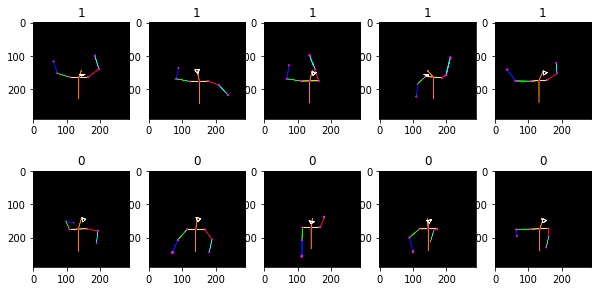

In [10]:
import numpy as np
import matplotlib.pyplot as plt

samples_per_class = 5
num_classes = len(labels)

y_data = np.array(y_data).reshape(-1)
x_data = np.array(x_data)

for y, item in enumerate(labels):
    idxs = np.flatnonzero(y_data == item)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        image = x_data[idxs[i]]
        image = image.reshape(288, 288, 3)
        label = y_data[idxs[i]]
        plt.subplot(num_classes, samples_per_class, i + 1 + y * samples_per_class)
        plt.imshow(image)
        plt.title(label)
        
plt.show()

## Search the best parameters for uniform weights

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier


metric = ["euclidean", "manhattan", "chebyshev"]
metric_count = len(metric)

n_neighbors = range(1, 6)
n_neghbors_count = len(n_neighbors)

weights = ["uniform", "distance"]
weights_count = len(weights)

classifier = KNeighborsClassifier(algorithm="kd_tree")
param_grid = {"weights": weights, "metric": metric, "n_neighbors": n_neighbors}
scoring = {"accuracy": make_scorer(accuracy_score),
           "recall": make_scorer(recall_score)}

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring,
                  cv=5, refit='accuracy', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])

results = gs.cv_results_
best_params = gs.best_params_
best_score = gs.best_score_

print(best_params)
print(best_score)

{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.5700000000000001


## Process results

In [58]:
best_weight_id = weights.index(best_params["weights"])
best_metric_id = metric.index(best_params["metric"])

### Extract and reshape results

In [81]:
keys = []
prep_result = {}

for score in scoring:
    keys.append("mean_test_%s" % (score))
    keys.append("mean_train_%s" % (score))
    keys.append("std_test_%s" % (score))
    keys.append("std_train_%s" % (score))
    keys.append("rank_test_%s" % (score))
    
for key in keys:
    res = results[key]
    res = res.reshape((metric_count, n_neghbors_count, weights_count))
    res = res.transpose(2, 0, 1)
    prep_result[key] = res

### Build hitmap

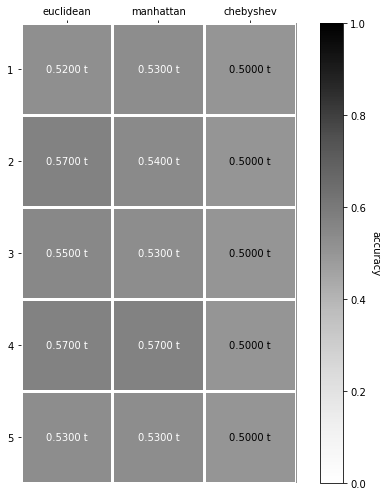

In [82]:
from heat_map import heatmap, annotate_heatmap

heatmap_metric = "accuracy"
mean_test_score = prep_result["mean_test_%s" % (heatmap_metric)][best_weight_id]
mean_test_score = mean_test_score.transpose(1, 0)

plt.rcParams["figure.figsize"]=[7, 7]
fig, ax = plt.subplots()

im, cbar = heatmap(mean_test_score, n_neighbors, metric, ax=ax, cmap="Greys", vmin=0, vmax=1, cbarlabel=heatmap_metric)
texts = annotate_heatmap(im, valfmt="{x:.4f} t", textcolors=["black", "white"], threshold=0.5)

fig.tight_layout()
plt.show()

### Show plot for the best weight and metric

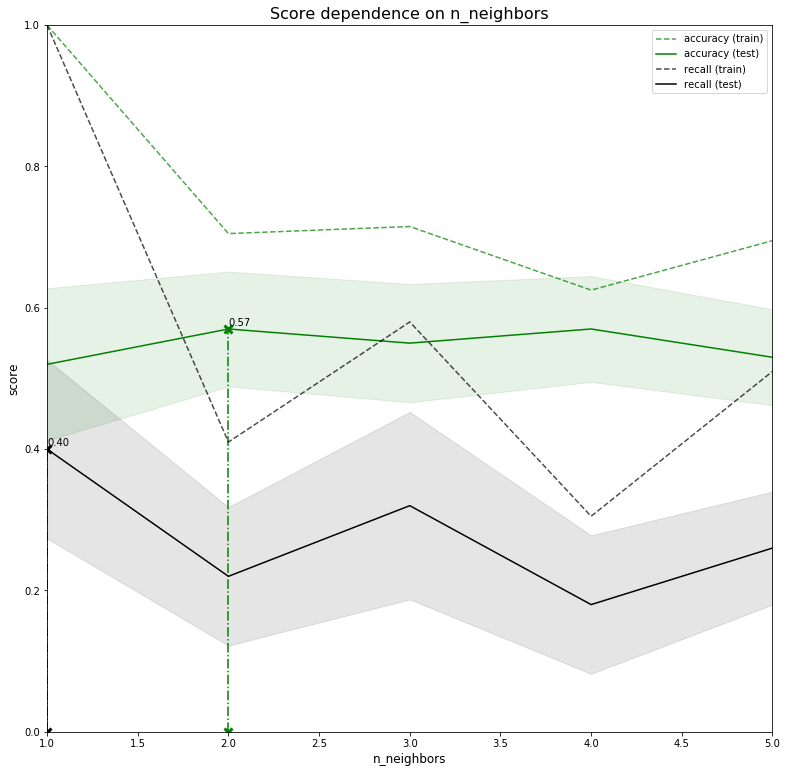

In [84]:
plt.figure(figsize=(13, 13))
plt.title("Score dependence on n_neighbors",
          fontsize=16)

plt.xlabel("n_neighbors", fontsize=12)
plt.ylabel("score", fontsize=12)

ax = plt.gca()
ax.set_xlim(1, n_neghbors_count)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(n_neighbors, dtype=int)
    

for scorer, color in zip(sorted(scoring), ['g', 'k', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = prep_result['mean_%s_%s' % (sample, scorer)][best_weight_id][best_metric_id]
        sample_score_std = prep_result['std_%s_%s' % (sample, scorer)][best_weight_id][best_metric_id]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    rank_test = prep_result['rank_test_%s' % scorer][best_weight_id][best_metric_id]
    best_rank = rank_test.min()
    best_index = np.nonzero(rank_test == best_rank)[0][0]
    best_score = prep_result['mean_test_%s' % scorer][best_weight_id][best_metric_id][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()